# Exp 39

### Single model to detect randomness

In [1]:
import os
import datetime
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

import models
import report
import block_sampler
import batch_encoder
from dataset import Dataset
from report import Reporter
from trainer import Trainer
from batch_encoder import Dataset
from block_sampler import count_sectors, BlockSamplerByCategory, RandomSampler
from batch_encoder import xs_encoder_8bits_11, BatchEncoder
from filter_random import gen_rndchk_models, evaluate_rnd_model, filter_dataset

/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [11]:
# raw_dataset_folder='/home/user/sample200'
raw_dataset_folder='../datasets/govdocs1/sample200'
random_dataset_folder='../datasets/random'
minimum=200
maximum=200
result_dir = 'results/exp39'
os.makedirs(result_dir, exist_ok=True)

In [3]:
rawset = Dataset.new_from_folders(raw_dataset_folder).filter_min_max(minimum, maximum)
rawset = rawset.filter(lambda x: rawset.category_from(x) not in ['text', 'unk'])
rawset.rebuild_categories()
rndset = Dataset.new_from_folders(random_dataset_folder) #.filter_min_max(minimum, maximum)

In [12]:
import models
from block_sampler import BlockSamplerByCategory
from batch_encoder import BatchEncoder
from collections import namedtuple
import callbacks
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

TrainResults = namedtuple(
    'TrainResults', ['model', 'history', 'metrics', 'elapsed'])

def adjustSamplingProbs(model, tset, xs_encoder, target_sampler):
    datasets = tset.by_category()
    encoders = {}
    for cat in datasets:
        tsampler = BlockSamplerByCategory(tset)
        trsampler = RandomSampler(tsampler, ratio=0.0)
        tbenc = BatchEncoder(trsampler, 100, xs_encoder=xs_encoder)
        encoders[cat] = iter(tbenc)
    def f(epoch, logs):
        results = {}
        for cat in encoders:
            result = model.evaluate_generator(
                encoders[cat],
                steps=1
            )
            results[cat] = result[-1]
        cat_prob = {}
        for cat, x in results.items():
            cat_prob[cat] = 1 + int((1-x)*100)
        print(cat_prob)
        target_sampler.category_prob = cat_prob
    return f
    

class RandomTrainer:
    def __init__(self,
                 model,
                 xs_encoder='8bits_11',
                 validation_steps=20,
                 steps_per_epoch=10,
                 epochs=10000000,
                 max_seconds=10*60,
                 batch_size=400,
                 min_delta=1e-03,
                 patience=4):
        self.model = model
        self.xs_encoder = xs_encoder
        self.validation_steps = validation_steps
        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs
        self.max_seconds = max_seconds
        self.batch_size = batch_size
        self.min_delta = min_delta
        self.patience = patience

    def train(self, tset, vset):
        tsampler = BlockSamplerByCategory(tset)
        trsampler = RandomSampler(tsampler)
        tbenc = BatchEncoder(trsampler, self.batch_size,
                             xs_encoder=self.xs_encoder)

        vsampler = BlockSamplerByCategory(vset)
        vrsampler = RandomSampler(tsampler)
        vbenc = BatchEncoder(vrsampler, self.batch_size,
                             xs_encoder=self.xs_encoder)

        model = self.model

        timeIt = callbacks.TimeIt()

        history = model.fit_generator(iter(tbenc),
                                      validation_data=iter(vbenc),
                                      validation_steps=self.validation_steps,
                                      steps_per_epoch=self.steps_per_epoch,
                                      epochs=self.epochs,
                                      verbose=1,
                                      callbacks=[
            LambdaCallback(on_epoch_end=adjustSamplingProbs(model, tset,
                                                            self.xs_encoder, trsampler)),
            timeIt,
            # callbacks.SaveModel(os.path.join(result_dir, model.name + '.h5')),
            callbacks.TimeLimit(self.max_seconds),
            EarlyStopping(monitor='val_categorical_accuracy',
                          min_delta=self.min_delta, patience=self.patience),
            # TensorBoard(
            #     log_dir=os.path.join(log_dir, model.name),
            #     # update_freq=3100,
            # ),
        ],
            use_multiprocessing=False,
            workers=0,
        )
        return TrainResults(
            model=model,
            history=history,
            metrics=['val_binary_accuracy', 'val_categorical_accuracy'],
            elapsed=timeIt.elapsed,
        )

In [13]:
model = models.C64_16_2pr_C32_4_2pr_C64_32_2pr_F_D(
        2, 8, 'softmax', 'categorical_crossentropy')

In [14]:
rt = RandomTrainer(model)

In [15]:
result = rt.train(*rawset.rnd_split_fraction_by_category(0.5))

Epoch 1/10000000
10/10 [==============================] - 9s 914ms/step - loss: 0.5066 - categorical_accuracy: 0.7390 - binary_accuracy: 0.7390 - val_loss: 0.3863 - val_categorical_accuracy: 0.8360 - val_binary_accuracy: 0.8360
Epoch 2/10000000
10/10 [==============================] - 8s 781ms/step - loss: 0.3896 - categorical_accuracy: 0.8338 - binary_accuracy: 0.8338 - val_loss: 0.3701 - val_categorical_accuracy: 0.8369 - val_binary_accuracy: 0.8369
Epoch 3/10000000
10/10 [==============================] - 8s 773ms/step - loss: 0.3704 - categorical_accuracy: 0.8378 - binary_accuracy: 0.8378 - val_loss: 0.3534 - val_categorical_accuracy: 0.8474 - val_binary_accuracy: 0.8474
Epoch 4/10000000
10/10 [==============================] - 8s 776ms/step - loss: 0.3279 - categorical_accuracy: 0.8625 - binary_accuracy: 0.8625 - val_loss: 0.3074 - val_categorical_accuracy: 0.8754 - val_binary_accuracy: 0.8754
Epoch 5/10000000
10/10 [==============================] - 8s 769ms/step - loss: 0.3014 -

Epoch 14/10000000
10/10 [==============================] - 8s 778ms/step - loss: 0.2392 - categorical_accuracy: 0.9110 - binary_accuracy: 0.9110 - val_loss: 0.2340 - val_categorical_accuracy: 0.9129 - val_binary_accuracy: 0.9129
Epoch 15/10000000
10/10 [==============================] - 8s 785ms/step - loss: 0.2417 - categorical_accuracy: 0.9107 - binary_accuracy: 0.9107 - val_loss: 0.2398 - val_categorical_accuracy: 0.9091 - val_binary_accuracy: 0.9091
Epoch 16/10000000
10/10 [==============================] - 8s 767ms/step - loss: 0.2169 - categorical_accuracy: 0.9233 - binary_accuracy: 0.9233 - val_loss: 0.2302 - val_categorical_accuracy: 0.9139 - val_binary_accuracy: 0.9139
Epoch 17/10000000
10/10 [==============================] - 8s 759ms/step - loss: 0.2417 - categorical_accuracy: 0.9075 - binary_accuracy: 0.9075 - val_loss: 0.2241 - val_categorical_accuracy: 0.9153 - val_binary_accuracy: 0.9153
Epoch 18/10000000
10/10 [==============================] - 8s 774ms/step - loss: 0.2

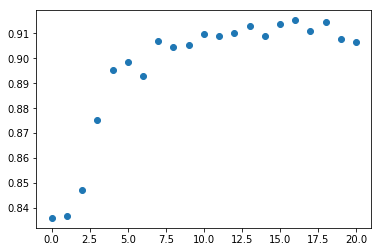

In [16]:
plt.plot(result.history.history['val_categorical_accuracy'], 'o')

In [17]:
result

TrainResults(model=<tensorflow.python.keras.engine.training.Model object at 0x7fd3040c6f60>, history=<tensorflow.python.keras.callbacks.History object at 0x7fd2dc74c898>, metrics=['val_binary_accuracy', 'val_categorical_accuracy'], elapsed=163.61029839515686)

In [18]:
result.model.save(result_dir + '/randomchk.h5')

r = report.Reporter2(result_dir + '/randomchk.tsv')
r.line(name=result.model.name,
       elapsed=result.elapsed,
       **report.report_epochs(**result._asdict()),
       **report.report_metrics(result.history, result.metrics),
      )
r.close()

In [21]:
pd.read_csv(result_dir + '/randomchk.tsv', sep='\t')

,name,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
0,C64_16_2pr_C32_4_2pr_C64_32_2pr_F_D2_cat,163.610298,21,0.9065,0.9065


# binary classifier



Epoch 1/10000000
10/10 [==============================] - 9s 934ms/step - loss: 0.5604 - categorical_accuracy: 0.7197 - binary_accuracy: 0.7210 - val_loss: 0.4138 - val_categorical_accuracy: 0.8425 - val_binary_accuracy: 0.8386
Epoch 2/10000000
10/10 [==============================] - 8s 777ms/step - loss: 0.3875 - categorical_accuracy: 0.8460 - binary_accuracy: 0.8462 - val_loss: 0.3625 - val_categorical_accuracy: 0.8506 - val_binary_accuracy: 0.8514
Epoch 3/10000000
10/10 [==============================] - 8s 780ms/step - loss: 0.3580 - categorical_accuracy: 0.8512 - binary_accuracy: 0.8501 - val_loss: 0.3526 - val_categorical_accuracy: 0.8478 - val_binary_accuracy: 0.8476
Epoch 4/10000000
10/10 [==============================] - 8s 777ms/step - loss: 0.3399 - categorical_accuracy: 0.8580 - binary_accuracy: 0.8571 - val_loss: 0.3359 - val_categorical_accuracy: 0.8572 - val_binary_accuracy: 0.8575
Epoch 5/10000000
10/10 [==============================] - 8s 761ms/step - loss: 0.3269 -

Epoch 14/10000000
10/10 [==============================] - 8s 761ms/step - loss: 0.2385 - categorical_accuracy: 0.9107 - binary_accuracy: 0.9101 - val_loss: 0.2266 - val_categorical_accuracy: 0.9147 - val_binary_accuracy: 0.9151
Epoch 15/10000000
10/10 [==============================] - 8s 765ms/step - loss: 0.2349 - categorical_accuracy: 0.9147 - binary_accuracy: 0.9146 - val_loss: 0.2403 - val_categorical_accuracy: 0.9101 - val_binary_accuracy: 0.9104
Epoch 16/10000000
10/10 [==============================] - 8s 772ms/step - loss: 0.2419 - categorical_accuracy: 0.9087 - binary_accuracy: 0.9084 - val_loss: 0.2416 - val_categorical_accuracy: 0.9080 - val_binary_accuracy: 0.9086
Epoch 17/10000000
10/10 [==============================] - 8s 783ms/step - loss: 0.2449 - categorical_accuracy: 0.9093 - binary_accuracy: 0.9085 - val_loss: 0.2419 - val_categorical_accuracy: 0.9107 - val_binary_accuracy: 0.9109
Epoch 18/10000000
10/10 [==============================] - 8s 777ms/step - loss: 0.2

Epoch 27/10000000
10/10 [==============================] - 8s 771ms/step - loss: 0.2496 - categorical_accuracy: 0.9053 - binary_accuracy: 0.9064 - val_loss: 0.2600 - val_categorical_accuracy: 0.8997 - val_binary_accuracy: 0.8999
Epoch 28/10000000
10/10 [==============================] - 8s 790ms/step - loss: 0.2481 - categorical_accuracy: 0.9047 - binary_accuracy: 0.9035 - val_loss: 0.2492 - val_categorical_accuracy: 0.9071 - val_binary_accuracy: 0.9071
Epoch 29/10000000
10/10 [==============================] - 8s 775ms/step - loss: 0.2438 - categorical_accuracy: 0.9072 - binary_accuracy: 0.9078 - val_loss: 0.2338 - val_categorical_accuracy: 0.9115 - val_binary_accuracy: 0.9118
Epoch 30/10000000
10/10 [==============================] - 8s 775ms/step - loss: 0.2263 - categorical_accuracy: 0.9172 - binary_accuracy: 0.9174 - val_loss: 0.2208 - val_categorical_accuracy: 0.9169 - val_binary_accuracy: 0.9162


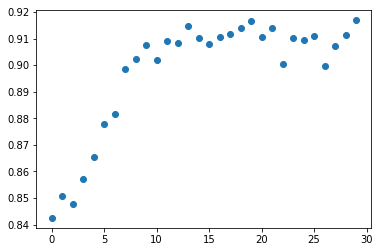

In [27]:
model = models.C64_16_2pr_C32_4_2pr_C64_32_2pr_F_D(
        2, 8, 'sigmoid', 'binary_crossentropy')

rt = RandomTrainer(model, patience=10)

result = rt.train(*rawset.rnd_split_fraction_by_category(0.5))

plt.plot(result.history.history['val_categorical_accuracy'], 'o')

result.model.save(result_dir + '/randomchk_bin.h5')

r = report.Reporter2(result_dir + '/randomchk_bin.tsv')
r.line(name=result.model.name,
       elapsed=result.elapsed,
       **report.report_epochs(**result._asdict()),
       **report.report_metrics(result.history, result.metrics),
      )
r.close()

In [28]:
result

TrainResults(model=<tensorflow.python.keras.engine.training.Model object at 0x7fd2d0590908>, history=<tensorflow.python.keras.callbacks.History object at 0x7fd2dc208240>, metrics=['val_binary_accuracy', 'val_categorical_accuracy'], elapsed=233.98343300819397)

In [29]:
pd.read_csv(result_dir + '/randomchk_bin.tsv', sep='\t')

,name,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
0,C64_16_2pr_C32_4_2pr_C64_32_2pr_F_D2_cat,233.983433,30,0.91625,0.916875
